# Generating fibrous mats
In this notebook, we're learning how to use `porespy.generators.cylinders` method to generate images that mimic fibrous mats.

In [1]:
import time
import porespy as ps
import matplotlib.pyplot as plt
import numpy as np
ps.visualization.set_mpl_style()
np.random.seed(5)
ps.settings.tqdm["disable"] = True

The `cylinders` function works either by providing the number of cylinders or the target porosity. If the number of cylinders is given, the function tries to fit in that many cylinders in a bounding box defined by its shape.

When providing porosity, the function works by estimating the number of cylinders needed to be inserted into the domain by estimating cylinder length, and exploiting the fact that, when inserting any potentially overlapping objects randomly into a volume v_total (which has units of pixels and is equal to dimx x dimy x dimz, for example), such that the total volume of objects added to the volume is v_added (and includes any volume that was inserted but overlapped with already occupied space), the resulting porosity will be equal to:

$$\epsilon = \exp(-\frac{V_{added}}{V_{total}})$$

After intially estimating the cylinder number and inserting a small fraction of the estimated number, the true cylinder volume is calculated, the estimate refined, and a larger fraction of cylinderss inserted. This is repeated a number of times according to the ``maxiter`` argument, yielding an image with a porosity close to the goal.

This first example shows that the output images are similar to the output of `cylinders` when providing the number of cylinders (for an image with the same number of cylinders), and that the goal porosity is reached.

In [2]:
dim = 200
shape = [dim, dim, dim]
radius = 4
phi_max = 0
theta_max = 90
length = None
maxiter = 3
target_porosity = 0.8

Let's first store the generic arguments in a dictionary so we can easily pass it to `cylinders` method.

In [3]:
params_generic = {
    "shape": shape,
    "r": radius,
    "phi_max": phi_max,
    "theta_max": theta_max,
    "length": length,
    "maxiter": maxiter    
}

Generate image by providing the target porosity:

In [4]:
im_using_porosity = ps.generators.cylinders(**params_generic, porosity=target_porosity)
print(f"Output porosity is {ps.metrics.porosity(im_using_porosity)}.")

Output porosity is 0.801341125.


Now generate another image by providing the number of cylinders rather than porosity.

In [5]:
im_using_ncylinders = ps.generators.cylinders(**params_generic, ncylinders=293)
three_d1 = ps.visualization.show_3D(im_using_porosity)
three_d2 = ps.visualization.show_3D(im_using_ncylinders)

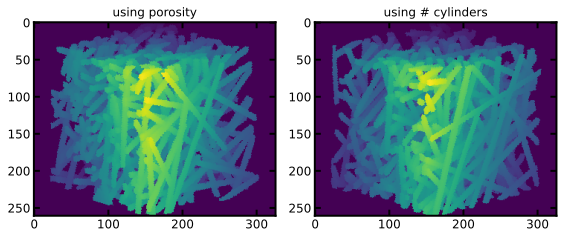

In [6]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])
ax[0].imshow(three_d1)
ax[1].imshow(three_d2)
ax[0].set_title("using porosity")
ax[1].set_title("using # cylinders");

This next block shows that the time penalty over inserting the same number of fibers using generators.cylinders is about 2x, and the time penalty ratio increases with requested porosity, when image generation is faster anyway.

In [7]:
porosity_target = [0.1, 0.4, 0.8, 0.95]
porosity_actual = []
runtime_ratios = []
runtime_porosity = []
runtime_ncylinder = []

for eps in porosity_target:
    temp = time.time()
    im = ps.generators.cylinders(**params_generic, porosity=eps)
    runtime_porosity.append(time.time() - temp)
    porosity_actual.append(ps.metrics.porosity(im))

In [8]:
# The number of cylinders added during the previous phase
ncylinders = [3033, 1143, 294, 75]

for ncylinder in ncylinders:
    temp = time.time()
    im = ps.generators.cylinders(**params_generic, ncylinders=ncylinder)
    runtime_ncylinder.append(time.time() - temp)

runtime_ratios = [t1 / t2 for (t1, t2) in zip(runtime_porosity, runtime_ncylinder)]

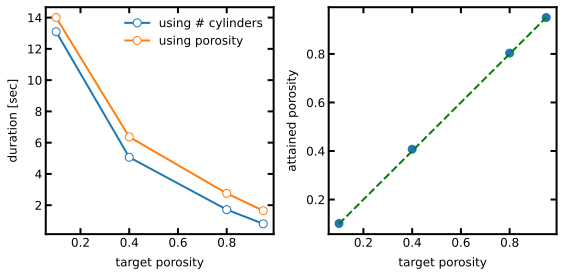

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(porosity_target, runtime_ncylinder, "o-", label='using # cylinders')
ax[0].plot(porosity_target, runtime_porosity, "o-", label='using porosity')
ax[0].set_xlabel('target porosity');
ax[0].set_ylabel('duration [sec]');
ax[0].legend()

ax[1].scatter(porosity_target, porosity_actual)
ax[1].plot(porosity_target, porosity_target, "g--")
ax[1].set_xlabel('target porosity')
ax[1].set_ylabel('attained porosity');

Lastly, this block shows that more iterations improves proximity to goal porosity.

In [10]:
porosity_target = 0.85
porosity_actual = []
maxiter = range(0, 10)

for m in maxiter:
    # Update maxiter in params_generic
    params_generic.update({"maxiter": m})
    im = ps.generators.cylinders(**params_generic, porosity=porosity_target)
    porosity_actual.append(ps.metrics.porosity(im))

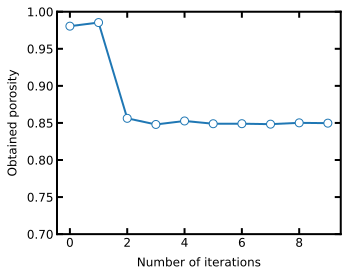

In [11]:
fig, ax = plt.subplots(figsize=(5, 4));
ax.plot(maxiter, porosity_actual, "o-")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Obtained porosity")
ax.set_ylim((0.7, 1));